In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics
encoder = LabelEncoder()


In [84]:
# train the model using the Randomized Search
def trainModel(model, param_distributions, X_trn, y_trn, data_name, **kwargs):
    clf = model(**kwargs)
    print('Trainning', clf.__class__.__name__ ,' model with ' , data_name , 'data...')
    
    #use standard scaler to scale the data
    scaler = sklearn.preprocessing.StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    
    search = sklearn.model_selection.RandomizedSearchCV(clf, param_distributions)
    search.fit(X_trn, y_trn)
    best_param = search.best_params_
    print('using' , search.best_estimator_)
    clf = model(**kwargs)
    clf.set_params(**best_param)
    clf.fit(X_trn, y_trn)
    return clf

# train the model using the Grid Search
def trainModelGridSearch(model, param_distributions, X_trn, y_trn, data_name, **kwargs):
    clf = model(**kwargs)
    print('Trainning', clf.__class__.__name__ ,' model with ' , data_name , 'data...')
    
    #use standard scaler to scale the data
    scaler = sklearn.preprocessing.StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    
    search = sklearn.model_selection.GridSearchCV(clf, param_distributions)
    search.fit(X_trn, y_trn)
    best_param = search.best_params_
    print('using' , search.best_estimator_)
    clf = model(**kwargs)
    clf.set_params(**best_param)
    clf.fit(X_trn, y_trn)
    return clf

# compute the score of the input estimator
def computeScore(estimator, X_test, y_test, data_name):
    scaler = sklearn.preprocessing.StandardScaler()
    X_test = scaler.fit_transform(X_test)
    y_pred = estimator.predict(X_test)
    score = np.mean((y_test-y_pred)**2)*100
    #score = round(estimator.score(X_test, y_test), 2 )* 100
    print('testing accuracy using ', estimator.__class__.__name__, 'for data', data_name , score, '%')
    print()
    return score

def separateData(X,y):
    X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
    return X_trn, X_tst, y_trn, y_tst

In [85]:
# Train all the classifiers with different 
def train_with_all_classifier(X_trn, y_trn, data_name, X_tst, y_tst):
    import warnings
    warnings.filterwarnings("ignore")
    estimators = []
    scores = []
    
    #Linear Regression
    logistic_estimator = sklearn.linear_model.LinearRegression()
    print('Training Linear regression model with ' , data_name , 'dataset')
    logistic_estimator.fit(X_trn,y_trn)
    estimators.append(logistic_estimator)
    scores.append(computeScore(logistic_estimator, X_tst, y_tst, data_name))
    
    #SVM
    param_distributions = {
        'C' : [0.01,0.1,1.0],
        'gamma' : [0.1,0.5,2.0]
    }
    
    svr_estimator = trainModelGridSearch(sklearn.svm.SVR, param_distributions, X_trn, 
                                         y_trn, data_name, max_iter = 1)
    estimators.append(svr_estimator)
    scores.append(computeScore(svr_estimator, X_tst, y_tst, data_name))

    
    #Decision Tree Classifier
    param_distributions = {
            'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'max_depth' : [2,4,6]
    }
    decision_tree_estimator = trainModel(sklearn.tree.DecisionTreeRegressor, param_distributions, X_trn, 
                                         y_trn, data_name)
    estimators.append(decision_tree_estimator)
    scores.append(computeScore(decision_tree_estimator, X_tst, y_tst, data_name))
    
    #Random Forest Classifier
    param_distributions = {
            'n_estimators' : [50,100,200],
            'max_depth' : [1,2,4]
    }
    randomForest_estimator = trainModel(sklearn.ensemble.RandomForestRegressor, param_distributions, X_trn, 
                                         y_trn, data_name)
    estimators.append(randomForest_estimator)
    scores.append(computeScore(randomForest_estimator, X_tst, y_tst, data_name))
    
    #KNeighborsRegressor
    param_distributions = {
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'n_neighbors' : [5,10,20]
    }
    kneighbours_estimator = trainModel(sklearn.neighbors.KNeighborsRegressor, param_distributions, X_trn, 
                                         y_trn, data_name)
    estimators.append(kneighbours_estimator)
    scores.append(computeScore(kneighbours_estimator, X_tst, y_tst, data_name))
    
    #Adaboost
    param_distributions = {
            'n_estimators' : [10, 30, 50,100],
            'learning_rate' : [0.2,1.0,1.2,2.0]
    }
    Adaboost_estimator = trainModel(sklearn.ensemble.AdaBoostRegressor, param_distributions, X_trn, 
                                         y_trn, data_name, random_state=0)
    estimators.append(Adaboost_estimator)
    scores.append(computeScore(Adaboost_estimator, X_tst, y_tst, data_name))
    
    
    #GaussianProcessRegressor
    param_distributions = {
            'alpha' : [0.00000001,0.001,1,10,100],
            'n_restarts_optimizer' : [0,1,2,3]
    }
    Gaussian_estimator = trainModel(sklearn.gaussian_process.GaussianProcessRegressor, param_distributions, X_trn, 
                                         y_trn, data_name, random_state=0)
    estimators.append(Gaussian_estimator)
    scores.append(computeScore(Gaussian_estimator, X_tst, y_tst, data_name))

    
    #neural_network MLPRegressor
    param_distributions = {
            'hidden_layer_sizes' : [5,10,50,60],
            'learning_rate' : ['constant', 'invscaling', 'adaptive']
    }
    Neural_estimator = trainModel(sklearn.neural_network.MLPRegressor, param_distributions, X_trn, 
                                         y_trn, data_name, max_iter = 1, random_state=0)
    estimators.append(Neural_estimator)
    scores.append(computeScore(Neural_estimator, X_tst, y_tst, data_name))
    print('---------------------------------------------------')
    return estimators, scores


In [83]:
def plotBarGraph(score_list, title):
    classifier_list = ['Linear Regression', 'SVR', 'DecisionTreeRegressor','RandomForestRegressor','KNeighborsRegressor',
                   'AdaBoostRegressor', 'GaussianProcessRegressor','MLPRegressor']
    # x-coordinates of left sides of bars
    left = []
    scores = []
    # labels for bars
    #tick_label = classifier_list
    tick_label = []
    plt.figure(figsize=(18,5))
    plt.grid(zorder=0)
    
    plt.title(title)
    for i in range(len(score_list)):
        if score_list[i] < -10 or score_list[i] > 100:
            scores.append(0)
        else:
            scores.append(score_list[i])
        left.append(i+1)
        tick_label.append(classifier_list[i])
            
    plt.bar(left, scores, tick_label = tick_label,
            width = 0.2, color = ['red', 'green'])
   # print(scores)
    best_score = max(scores)
    plt.text(6, 60, 'best accuracy estimator = ' + classifier_list[score_list.index(best_score)] + ' score: '+ str(best_score) + ' %' , fontsize=15, color = 'brown')

# =====================Dataset 1. Wines==========================
Since we have white and red wine, let us initialize a new row: color in which it is equal to 1 when the wine is a white wine, 0 if it is red.

In [54]:
# Extracting the data

whiteWine = pd.read_csv('resources2/winequality-white.csv',sep=';')
redWine = pd.read_csv('resources2/winequality-red.csv',sep=';')
color =[]
# 0 is for white color and 1 is for red color
for i in range(len(whiteWine)):
    color.append(0)
for j in range(len(redWine)):
    color.append(1)


bothWines = pd.concat([whiteWine, redWine], axis=0)
bothWines['color'] = color

X = bothWines.drop('quality', axis='columns')
y = bothWines['quality']


X_trn_wine,X_tst_wine,y_trn_wine,y_tst_wine = train_test_split(X,y,random_state=0)

display(bothWines)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


In [86]:
%%time
wine_estimators, wine_scores = train_with_all_classifier(X_trn_wine, y_trn_wine,
                                                                 'Wine', X_tst_wine,y_tst_wine)


Training Linear regression model with  Wine dataset
testing accuracy using  LinearRegression for data Wine 1896690.3713077598 %

Trainning SVR  model with  Wine data...
using SVR(gamma=0.1, max_iter=1)
testing accuracy using  SVR for data Wine 75.24703001479254 %

Trainning DecisionTreeRegressor  model with  Wine data...
using DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)
testing accuracy using  DecisionTreeRegressor for data Wine 55.67745987207604 %

Trainning RandomForestRegressor  model with  Wine data...
using RandomForestRegressor(max_depth=4, n_estimators=200)
testing accuracy using  RandomForestRegressor for data Wine 52.04970480569343 %

Trainning KNeighborsRegressor  model with  Wine data...
using KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20)
testing accuracy using  KNeighborsRegressor for data Wine 48.39876923076923 %

Trainning AdaBoostRegressor  model with  Wine data...
using AdaBoostRegressor(learning_rate=0.2, n_estimators=100, random_state=0)


KeyboardInterrupt: 

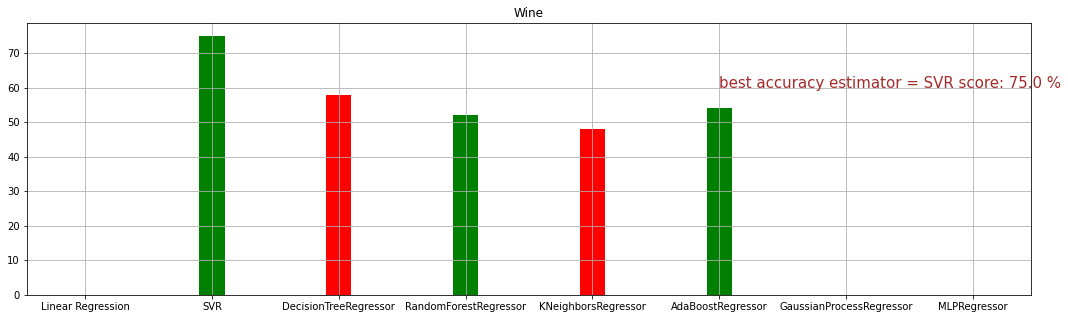

In [62]:
plotBarGraph(wine_scores, 'Wine')

# ===============Dataset 2. Communities and Crimes===============

In [66]:
data = pd.read_csv('resources2/communities.data',sep=',',header=None, skipinitialspace=True)
# encode by converting to int
print('before encoding')
display(data)
for i in range(0, 128):
    data[i] = encoder.fit_transform(data[i])

X = data.drop(127, axis='columns')
y = data[127]

print('after encoding')
display(data)
X_trn_crime, X_tst_crime, y_trn_crime, y_tst_crime = separateData(X,y)

before encoding


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


after encoding


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,5,108,799,804,0,19,28,2,88,12,...,12,26,20,6,4,62,1,17,14,20
1,42,108,799,1625,0,0,11,12,72,45,...,2,12,45,63,38,72,3,0,51,67
2,18,108,799,1,0,0,37,49,54,17,...,1,21,2,63,38,72,3,0,51,43
3,25,56,725,1787,0,4,71,99,6,12,...,2,39,28,63,38,72,3,0,51,12
4,33,105,517,141,0,1,50,2,93,9,...,4,9,2,63,38,72,3,0,51,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,9,108,799,1597,9,1,35,10,85,12,...,1,28,5,63,38,72,3,0,51,9
1990,4,108,799,1455,9,5,88,46,26,78,...,2,37,20,63,38,72,3,0,51,45
1991,6,102,709,1707,9,16,32,25,67,4,...,8,32,18,8,6,50,0,73,28,23
1992,19,34,621,1695,9,8,46,6,85,22,...,3,38,33,2,2,51,0,7,18,19


In [67]:
%%time
crime_estimators, crime_scores = train_with_all_classifier(X_trn_crime, y_trn_crime,
                                                                 'Communities and Crimes', X_tst_crime,y_tst_crime)

Training Linear regression model with  Communities and Crimes dataset
testing accuracy using  LinearRegression for data Communities and Crimes 318117.0 %

Trainning SVR  model with  Communities and Crimes data...
using SVR(gamma=0.5, max_iter=1)
testing accuracy using  SVR for data Communities and Crimes 118236.99999999999 %

Trainning DecisionTreeRegressor  model with  Communities and Crimes data...
using DecisionTreeRegressor(criterion='absolute_error', max_depth=4)
testing accuracy using  DecisionTreeRegressor for data Communities and Crimes 27689.999999999996 %

Trainning RandomForestRegressor  model with  Communities and Crimes data...
using RandomForestRegressor(max_depth=4)
testing accuracy using  RandomForestRegressor for data Communities and Crimes 21330.0 %

Trainning KNeighborsRegressor  model with  Communities and Crimes data...
using KNeighborsRegressor(algorithm='kd_tree', n_neighbors=20)
testing accuracy using  KNeighborsRegressor for data Communities and Crimes 24231.0 

In [ ]:
plotBarGraph(crime_scores, 'Communities and Crime')

# ======================Dataset 3.  =========================

In [ ]:
#Preparing data for traing
#getting the default dataset
#aquaticToxicity
#since the data does not have label, so using the data description we have to label the data 
aquaticToxicity = pd.read_csv('resources2/qsar_aquatic_toxicity.csv',sep=';',names=["TPSA(Tot)","SAacc","H-050","MLOGP","RDCHI","GATS1p","nN","C-040","LC50"])


X = aquaticToxicity.drop('LC50', axis='columns')
aquaticToxicity['LC50'] = encoder.fit_transform(aquaticToxicity['LC50'])
y = aquaticToxicity['LC50']
X['TPSA(Tot)'] = encoder.fit_transform(X['TPSA(Tot)'])
X['SAacc'] = encoder.fit_transform(X['SAacc'])
X['H-050'] = encoder.fit_transform(X['H-050'])
X['MLOGP'] = encoder.fit_transform(X['MLOGP'])
X['RDCHI'] = encoder.fit_transform(X['RDCHI'])
X['GATS1p'] = encoder.fit_transform(X['GATS1p'])
X['nN'] = encoder.fit_transform(X['nN'])
y_lis = []
for ele in y:
    if ele < 500:
        y_lis.append(1)
    else:
        y_lis.append(0)
y = np.array(y_lis)
display(aquaticToxicity)
print('X: after encoding')
display(X)

X_trn_QSAR,X_tst_QSAR,y_trn_QSAR,y_tst_QSAR = separateData(X,y)


In [ ]:
%%time
QSAR_estimators, QSAR_scores = train_with_all_classifier(X_trn_QSAR, y_trn_QSAR,
                                                                 'QSAR', X_tst_QSAR,y_tst_QSAR)

In [ ]:
plotBarGraph(QSAR_scores, 'QSAR aquatic toxicity')

# ===================Dataset 4. Facebook======================

In [ ]:
#importing the raw data

fbData = pd.read_csv('resources2/dataset_Facebook.csv',sep=';')

#we can see some of the rows have invalid data entries

#preprocessing the data
fbData.replace(r'^\s*$', np.nan, regex=True, inplace = True)
fbData.replace('?', np.nan, inplace = True)
#print(fbData.isnull().sum())

# as we are perdicting the total Intractions so we will not consider them 
unusefullFeatures = ['comment','like','share']
fbData = fbData.drop(columns= unusefullFeatures, axis=1)
fbData["Type"].value_counts()

# since datatype of "Type" is not interger, but we can make it integer by making four cloumns for each type ; link, photo, status, video
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(fbData["Type"])
encoded_df = pd.DataFrame(lb_results, columns=lb_style.classes_)
fbData = pd.concat([fbData,encoded_df], axis=1) 
cols = list(fbData)
cols.insert(1, cols.pop(cols.index('Link')))
cols.insert(2, cols.pop(cols.index('Photo')))
cols.insert(3, cols.pop(cols.index('Status')))
cols.insert(4, cols.pop(cols.index('Video')))
fbData = fbData.loc[:, cols]
fbData = fbData.drop(columns=['Type'],axis=1)
#putting common values into the missing ones
fbData = fbData.apply(lambda x: x.fillna(x.value_counts().index[0]))
fbData.shape
(500, 19)

#Since almost every raw data has outliers so we need to remove them 
outlierThresholdValue = np.percentile(fbData['Total Interactions'],90)
fbData = fbData[fbData['Total Interactions'] < outlierThresholdValue]
fbData.shape

#Spliting the processed data into training and test datasets
#fbX_train, fbX_test, fby_train, fby_test = train_test_split(fbData.iloc[:, 0:18].values, fbData.iloc[:, 18].values, test_size=0.33, random_state=0)
#scaler = StandardScaler()
#scaler.fit(fbX_train)
#fbx_train_scaled = scaler.transform(fbX_train)
#fbx_test_scaled = scaler.transform(fbX_test)
fbData
X = fbData.drop('Total Interactions', axis='columns')
y = fbData['Total Interactions']

X_trn_facebook, X_tst_facebook, y_trn_facebook, y_tst_facebook = separateData(X,y)

fbData

In [ ]:
%%time
facebook_estimators, facebook_scores = train_with_all_classifier(X_trn_facebook, y_trn_facebook,
                                                                 'Facebook metrics', X_tst_facebook,y_tst_facebook)

In [ ]:
plotBarGraph(facebook_scores, 'Facebook metrics')

# =====================Dataset 5. Biking=======================
- To minimize training time, we are cutting the data to only 5000 data rather than 17000+

In [ ]:
bikeHours = pd.read_csv('resources2/hour.csv')
X = bikeHours.drop('cnt', axis='columns')
y = bikeHours['cnt']

print('Before encoding')
display(bikeHours)

X['dteday'] = encoder.fit_transform(X['dteday'])
#X['temp'] = encoder.fit_transform(X['temp'])
#X['atemp'] = encoder.fit_transform(X['atemp'])
#X['windspeed'] = encoder.fit_transform(X['windspeed'])

X_trn_biking, X_tst_biking, y_trn_biking, y_tst_biking = separateData(X,y)

print('X: After encoding')
display(X)


In [ ]:
%%time
biking_estimators, biking_scores = train_with_all_classifier(X_trn_biking, y_trn_biking,
                                                                 'Facebook metrics', X_tst_biking,y_tst_biking)

In [ ]:
plotBarGraph(scores, 'Bike Sharing')

# ====================Dataset 6. Students=====================

In [ ]:
studentPortMarks = pd.read_csv('resources2/student-por.csv',sep=';',  skipinitialspace=True)

print('Before encoding')
display(studentPortMarks)

X = studentPortMarks.drop('G3', axis='columns')
y = studentPortMarks['G3']

X['school'] = encoder.fit_transform(X['school'])
X['sex'] = encoder.fit_transform(X['sex'])
X['address'] = encoder.fit_transform(X['address'])
X['famsize'] = encoder.fit_transform(X['famsize'])
X['Pstatus'] = encoder.fit_transform(X['Pstatus'])
X['Mjob'] = encoder.fit_transform(X['Mjob'])
X['Fjob'] = encoder.fit_transform(X['Fjob'])
X['reason'] = encoder.fit_transform(X['reason'])
X['guardian'] = encoder.fit_transform(X['guardian'])
X['schoolsup'] = encoder.fit_transform(X['schoolsup'])
X['schoolsup'] = encoder.fit_transform(X['schoolsup'])
X['famsup'] = encoder.fit_transform(X['famsup'])
X['paid'] = encoder.fit_transform(X['paid'])
X['activities'] = encoder.fit_transform(X['activities'])
X['nursery'] = encoder.fit_transform(X['nursery'])
X['higher'] = encoder.fit_transform(X['higher'])
X['internet'] = encoder.fit_transform(X['internet'])
X['romantic'] = encoder.fit_transform(X['romantic'])


print('X: After encoding')
display(X)

X_trn_students, X_tst_students, y_trn_students, y_tst_students = separateData(X,y)



In [ ]:
%%time
students_estimators, students_scores = train_with_all_classifier(X_trn_students, y_trn_students,
                                                                 'Students', X_tst_students,y_tst_students)

In [ ]:
plotBarGraph(students_scores, 'Student Performance')

# ===========Dateset 7. Concrete Compressive Strength===========

- It is suggested to have a compressive strength for concrete below 50, so let us create estimators where output gives 1 when 
- the compressive strength for concrete is > 50

In [ ]:
concreteData = pd.read_excel('resources2/Concrete_Data.xls')

X = concreteData.drop('Concrete compressive strength(MPa, megapascals) ', axis='columns')
y = concreteData['Concrete compressive strength(MPa, megapascals) ']

# encoding float numbers
X['Cement (component 1)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Cement (component 1)(kg in a m^3 mixture)'])
X['Blast Furnace Slag (component 2)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Blast Furnace Slag (component 2)(kg in a m^3 mixture)'])
X['Fly Ash (component 3)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Fly Ash (component 3)(kg in a m^3 mixture)'])
X['Water  (component 4)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Water  (component 4)(kg in a m^3 mixture)'])
X['Superplasticizer (component 5)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Superplasticizer (component 5)(kg in a m^3 mixture)'])
X['Coarse Aggregate  (component 6)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Coarse Aggregate  (component 6)(kg in a m^3 mixture)'])
X['Fine Aggregate (component 7)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Fine Aggregate (component 7)(kg in a m^3 mixture)'])
y = y.astype('uint8')
X_trn_concrete, X_tst_concrete, y_trn_concrete, y_tst_concrete = separateData(X,y)
print('Before encoding')
display(concreteData)
print('After encoding')
display(X)


In [ ]:
%%time
concrete_estimators, concrete_scores = train_with_all_classifier(X_trn_concrete, y_trn_concrete,
                                                                 'Concrete Compressive Strength', X_tst_concrete, y_tst_concrete)

In [ ]:
plotBarGraph(concrete_scores, 'Concrete Compressive Strength')

# ===================Dateset 8. GPU =================== 

In [ ]:
#extracting data
gpuData = pd.read_csv("resources2/sgemm_product.csv")
display(gpuData)
#checking null values
#print(gpuData.isnull().sum())
#Preparing the the dataset
X = gpuData[gpuData.columns[:-4]] 
y = (gpuData['Run1 (ms)']+gpuData['Run2 (ms)']+gpuData['Run3 (ms)']+gpuData['Run4 (ms)'])/4


#splitting the data into training and testing datasets
y = encoder.fit_transform(y)
X = X.astype('uint8')
y = y.astype('uint8')
X_trn_GPU, X_tst_GPU, y_trn_GPU, y_tst_GPU = separateData(X,y)

print('averaging the 4 different runs and use it as y- output data')
# only using 10000 data from all the existing data to maximize running time
X_trn_GPU = X_trn_GPU.iloc[0:10000,:]
y_trn_GPU = y_trn_GPU[0:10000]
X_tst_GPU = X_tst_GPU.iloc[0:2000,:]
y_tst_GPU = y_tst_GPU[0:2000]


In [ ]:
%%time
GPU_estimators, GPU_scores = train_with_all_classifier(X_trn_GPU, y_trn_GPU,
                                                                 'GPU', X_tst_GPU, y_tst_GPU)

In [ ]:
plotBarGraph(GPU_scores, 'SGEMM GPU kernel performance ')